<a href="https://colab.research.google.com/github/SisopTeam3-SoaTeam5/TP2/blob/main/HPC/Cuaderno_1_Grupo5_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduccion
Para girar la imagen utilizaremos conocimientos basicos de algebra, especificamente utilizaremos la siguiente matriz de transformacion...

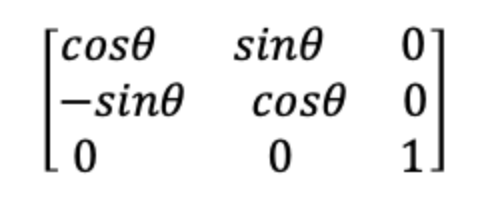

Donde θ es el angulo que se rotara la imagen.
Para lograr el resultado deseado a cada pixel de la imagen original se le asignara una nueva ubicacion (x , y) deifnida por la matriz ya mostrada. 

In [19]:

#@title ## Armado del ambiente
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/SisopTeam3-SoaTeam5/TP2/blob/main/HPC/images/apple--600.png?raw=true" #@param {type:"string"}
#@markdown ---
#@markdown ### Los grados que desea girar la imagen:
degrees = '90' #@param {type:"string"}
#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/SisopTeam3-SoaTeam5/TP2/blob/main/HPC/images/apple--600.png?raw=true -O imagen.jpg

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen} -O imagen.jpg
!pip install pycuda

--2021-11-22 14:23:19--  https://github.com/SisopTeam3-SoaTeam5/TP2/blob/main/HPC/images/apple--600.png?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SisopTeam3-SoaTeam5/TP2/raw/main/HPC/images/apple--600.png [following]
--2021-11-22 14:23:19--  https://github.com/SisopTeam3-SoaTeam5/TP2/raw/main/HPC/images/apple--600.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SisopTeam3-SoaTeam5/TP2/main/HPC/images/apple--600.png [following]
--2021-11-22 14:23:19--  https://raw.githubusercontent.com/SisopTeam3-SoaTeam5/TP2/main/HPC/images/apple--600.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

Tiempo de conversión de imagen: 1000.167 [ms]
Tiempo Total: 1053.829 [ms]


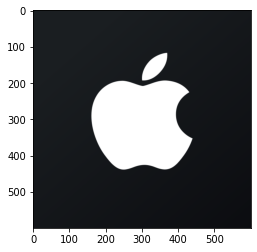

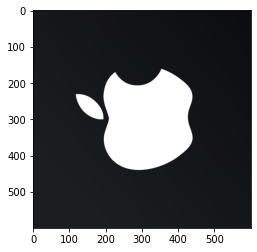

In [18]:
 %matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy 
from PIL import Image
import math

tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

#Convert degrees to radians
angle = numpy.deg2rad(int(degrees))

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre )

img_ancho, img_alto = image.width,image.height

img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )
img_picR_cpu = numpy.empty_like( img_pic_cpu)    



plt.figure()
imgplot=plt.imshow( img_pic_cpu )


center_hor=img_ancho/2
center_vert=img_alto/2

coseno=math.cos(angle)
seno=math.sin(angle)

tiempo_img = datetime.now()

for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
    xb = int(round(coseno*(x-center_vert) - seno*(y-center_hor) + center_hor))
    yb = int(round(coseno*(y-center_hor) + seno*(x-center_vert) + center_vert))
    if(xb>=0 and yb>=0 and xb<img_ancho and yb<img_alto):
      img_picR_cpu[y][x] = img_pic_cpu[yb][xb]
    else:
      img_picR_cpu[y][x]=255

tiempo_img = datetime.now() - tiempo_img

plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 66 kB 4.3 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627871 sha256=7e44a0f031544ebb53aca9715dfc4c8415605186bfaf0a95ad3b218b9538f3ae
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=47aaed832e448ea16efcaec76db12ffca5017120f2c0761dfc7cd2de9c58565f
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


Tiempo TOTAL:  61.535 [ms]
Tiempo GPU  :  0.458 [ms]


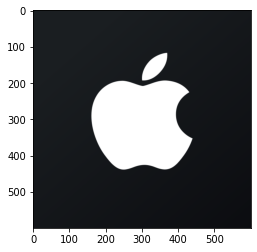

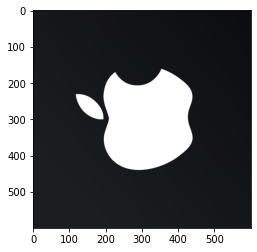

In [20]:
%matplotlib inline
from datetime import datetime

tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math

tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

#Convert degrees to radians
angle = numpy.deg2rad(int(degrees))

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre )

img_ancho, img_alto = image.width,image.height
#Convert image in array
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )
img_picR_cpu = numpy.empty_like( img_pic_cpu)    

#Pass arrays to GPU
img_pic_gpu = cuda.mem_alloc( img_pic_cpu.nbytes )
img_picR_gpu = cuda.mem_alloc( img_picR_cpu.nbytes )
cuda.memcpy_htod( img_pic_gpu, img_pic_cpu )
cuda.memcpy_htod( img_picR_gpu, img_picR_cpu )

center_hor=img_ancho/2
center_vert=img_alto/2

module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int center_hor,int center_vert,float seno, float coseno , int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    int xb = int(coseno*(idx-center_vert) - (seno)*(idy-center_hor) + center_hor);
    int yb = int(coseno*(idy-center_hor) + (seno)*(idx-center_vert) + center_vert);
    if(xb>=0 and yb>=0 and xb<ancho and yb<alto){
      img_R[(idx+(idy*ancho))*3] = img_O[(xb+(yb*ancho))*3];
      img_R[(idx+(idy*ancho))*3 + 1] = img_O[(xb+(yb*ancho))*3 +1];
      img_R[(idx+(idy*ancho))*3 + 2] = img_O[(xb+(yb*ancho))*3 +2];
    }
    else{
      img_R[(idx+(idy*ancho))*3]=255;
      img_R[(idx+(idy*ancho))*3 +1]=255;
      img_R[(idx+(idy*ancho))*3 +2]=255;
    }
  }
}
""") 
kernel = module.get_function("kernel_img")



dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

tiempo_img_gpu = datetime.now()

coseno=math.cos(angle)
seno=math.sin(angle)


kernel( numpy.int32(img_ancho), numpy.int32(img_alto),numpy.int32(center_hor),numpy.int32(center_vert),numpy.float32(seno),numpy.float32(coseno), img_pic_gpu, img_picR_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img_gpu = datetime.now() - tiempo_img_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_picR_cpu, img_picR_gpu )

# Muestro la imagen Original
plt.figure()
imgplot=plt.imshow( img_pic_cpu )

# Muestro la imagen luego
plt.figure()
imgplot=plt.imshow( img_picR_cpu )

tiempo_total_gpu = datetime.now() - tiempo_total_gpu

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total_gpu ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img_gpu ), "[ms]" )



In [28]:
print('------------------------------------------')
print('-           Seccion de metricas          -')
print('------------------------------------------')
print('| Metrica     |     CPU     |     GPU    |')
print('|-------------|-------------|------------|')
print('|Tiempo total |' , tiempo_en_ms( tiempo_total), "ms",'|', tiempo_en_ms(tiempo_total_gpu), 'ms', ' |')
print('|-------------|-------------|------------|')
print('|Tiempo imagen|' , tiempo_en_ms( tiempo_img), "ms",'|', tiempo_en_ms(tiempo_img_gpu), 'ms', '  |')
print('------------------------------------------')
 


------------------------------------------
-           Seccion de metricas          -
------------------------------------------
| Metrica     |     CPU     |     GPU    |
|-------------|-------------|------------|
|Tiempo total | 1053.829 ms | 61.535 ms  |
|-------------|-------------|------------|
|Tiempo imagen| 1000.167 ms | 0.458 ms   |
------------------------------------------


# Colclusiones 
Dado a las metricas obtenidas podemos afirmar sin duda que la implementacion de gpu es muchisimo mas rapido que la del cpu, esto dado al parelelismo que el gpu nos brinda. La ejecucion general llega a ser de entre 17 y 18 veces mas rapido. Y solamente el procesamiento de la imagen pixel por pixel llega a ser 2500 veces mas rapido. Claramente se nota el beneficio de utilizar el paralelismo que nos brinda la gpu.

# Bibliografia


1.   Single Precision Mathematical Functions: [CUDA DOCS](https://docs.nvidia.com/cuda/cuda-math-api/group__CUDA__MATH__SINGLE.html)
2.   Rotate An Image Using Python Image Processing Library: [ARTICULO](https://pythontic.com/image-processing/pillow/rotate)

3. Prueba 2 - Imagen - GPU: [GITHUB](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb)